# **Mounting google drive file system**

In [103]:
from google.colab import drive
drive.mount('/content/drive/')


Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


#**Checking Up data**

In [104]:
# SNIPPET TO LOAD DATA FROM DIRECTORY, FOR MANUAL WORK WITHOUT GENERATORS

import cv2
import glob
import numpy as np
import matplotlib.pyplot as plt

x_data = []
images_healthy = glob.glob ('/content/drive/My Drive/CAI/healthy_vs_sicks/v_data2/training/healthy/*.jpg')
images_sick = glob.glob ('/content/drive/My Drive/CAI/healthy_vs_sicks/v_data2/training/sicks/*.jpg')

print ('healthy count ' + str(len(images_healthy)))
print ('sick count ' + str(len(images_sick)))

'''
for image_source in images:
    image = cv2.imread (image_source)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    x_data.append (image)

print('x_data shape:', np.array(x_data).shape)

plt.imshow(x_data[0])
'''

healthy count 41
sick count 50


"\nfor image_source in images:\n    image = cv2.imread (image_source)\n    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)\n    x_data.append (image)\n\nprint('x_data shape:', np.array(x_data).shape)\n\nplt.imshow(x_data[0])\n"

# **Setting up constants**

In [0]:
TRAINING_DIR = '/content/drive/My Drive/CAI/healthy_vs_sicks/v_data2/training'
TEST_DIR = '/content/drive/My Drive/CAI/healthy_vs_sicks/v_data2/tests'
SEED = 101
IMAGE_SIZE = 224
CHANNELS = 3 # red, green, blue

# **Function definitions**



*   buildModel
*   buildModelFromDisk
*   getHyperparameters
*   getTrainingHyperparameters
*   buildSampleFromDisk





## **Hyperparameters**

In [0]:
'''
  Hyperparameters used to compile the model
'''

from keras.optimizers import RMSprop, Adadelta, Adam, SGD

def getHyperparameters():
  OPTIMIZER = SGD(1e-3)
  LOSS = 'categorical_crossentropy'
  METRICS = ['categorical_accuracy']

  return (LOSS, OPTIMIZER, METRICS)

## **Training parameters**

In [0]:
'''
  Hyperparameters that are used only for training phase, e.g, number of epochs,
  batch size.
'''

from keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, EarlyStopping

def getTrainingHyperparameters():
  reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=45, verbose=1) 
  early_stop = EarlyStopping(patience=30, restore_best_weights=True)
  model_checkpoint = ModelCheckpoint('./checkpoint.h5', monitor='val_loss', save_best_only=True, verbose=1)

  CALLBACK = [
    reduce_lr,
    model_checkpoint
  ]

  BATCH_SIZE = 32
  EPOCHS = 250

  return (EPOCHS, BATCH_SIZE, CALLBACK)

##**buildModel**

In [0]:
'''
  Model architecture definiton, including layers, initializers, activations and more
'''

from keras.layers import Dense, Input, Conv2D, Flatten, MaxPool2D, Dropout, GlobalAveragePooling2D, BatchNormalization, LeakyReLU
from keras.models import Model
from keras.initializers import Constant
from keras.regularizers import l2

kernel_regularizer = l2(0.1)
activity_regularizer = l2(0.001)

def buildModel():
  i = Input(shape=(IMAGE_SIZE, IMAGE_SIZE, CHANNELS))
  d = Conv2D(filters=16, kernel_size=(7,7), kernel_initializer='glorot_uniform', bias_initializer=Constant(0.1))(i)
  d = LeakyReLU(0.01)(d)
  d = BatchNormalization()(d)
  d = Conv2D(filters=32, kernel_size=(7,7) , kernel_initializer='glorot_uniform', bias_initializer=Constant(0.1))(d)
  d = LeakyReLU(0.01)(d)
  d = MaxPool2D(pool_size=(2,2))(d)
  d = BatchNormalization()(d)
  d = Conv2D(filters=64, kernel_size=(5,5), kernel_initializer='glorot_uniform', bias_initializer=Constant(0.1))(d)
  d = LeakyReLU(0.01)(d)
  d = GlobalAveragePooling2D()(d)
  d = BatchNormalization()(d)
  d = Dense(64, activation='relu', kernel_initializer='glorot_uniform', bias_initializer=Constant(0.1), activity_regularizer=activity_regularizer)(d)
  d = Dropout(0.30)(d)
  d = Dense(2, activation='softmax', kernel_initializer='glorot_uniform', bias_initializer=Constant(0.1))(d)

  model = Model(inputs=i, outputs=d)

  (LOSS, OPTIMIZER, METRICS) = getHyperparameters()

  model.compile(loss=LOSS, optimizer=OPTIMIZER, metrics=METRICS)

  return model


##**buildModelFromDisk**

In [0]:
from keras.models import load_model

def buildModelFromDisk(path='model.h5'):
  model = load_model(path, compile=False)

  return model

##**buildSampleFromDisk**

In [0]:
import numpy as np
from keras.preprocessing import image

def buildSampleFromDisk(img_path: str):
  original_test_image = image.load_img(img_path, target_size=(IMAGE_SIZE,IMAGE_SIZE))
    
  test_image = image.img_to_array(original_test_image)

  test_tensor = np.reshape(test_image, (1, IMAGE_SIZE, IMAGE_SIZE, CHANNELS))

  test_tensor = test_tensor / 255

  return (original_test_image, test_tensor)


# **Training**


In [0]:
(LOSS, OPTIMIZER, METRICS) = getHyperparameters()
(EPOCHS, BATCH_SIZE, CALLBACKS) = getTrainingHyperparameters()

## **Generators**

In [115]:
from keras.preprocessing.image import ImageDataGenerator
# Create data generators to load images from disk and do data augmentation


data_generator = ImageDataGenerator(
  rescale=1./255,
  validation_split=0.2,
  rotation_range = 10,
  width_shift_range=0.2,
  horizontal_flip=True,
  vertical_flip=True
)

train_generator = data_generator.flow_from_directory(
  TRAINING_DIR,
  target_size=(IMAGE_SIZE, IMAGE_SIZE),
  shuffle=True,
  seed=SEED,  
  class_mode='categorical',
  batch_size=BATCH_SIZE,
  subset="training"
)

validation_generator = data_generator.flow_from_directory(
  TRAINING_DIR,
  target_size=(IMAGE_SIZE, IMAGE_SIZE),
  shuffle=False,
  seed=SEED,
  class_mode='categorical',
  batch_size=BATCH_SIZE,
  subset="validation"
)

Found 81 images belonging to 2 classes.
Found 20 images belonging to 2 classes.


##**Fit**

Model: "model_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
conv2d_19 (Conv2D)           (None, 218, 218, 16)      2368      
_________________________________________________________________
leaky_re_lu_19 (LeakyReLU)   (None, 218, 218, 16)      0         
_________________________________________________________________
batch_normalization_19 (Batc (None, 218, 218, 16)      64        
_________________________________________________________________
conv2d_20 (Conv2D)           (None, 212, 212, 32)      25120     
_________________________________________________________________
leaky_re_lu_20 (LeakyReLU)   (None, 212, 212, 32)      0         
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 106, 106, 32)      0   

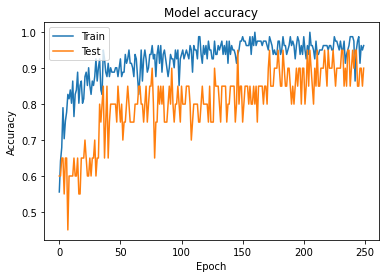

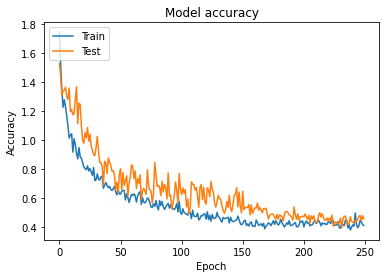

In [116]:
import matplotlib.pyplot as plt
import numpy as np 
from keras.metrics import categorical_crossentropy, categorical_accuracy

model = buildModel()

model.summary()

history = model.fit_generator(
  train_generator,
  epochs=EPOCHS,
  validation_data=validation_generator,
  shuffle=True,
  callbacks=CALLBACKS
)

model.save('./model.h5')

# Plot step by step movements of the accuracy metric

plt.plot(history.history['categorical_accuracy'])
plt.plot(history.history['val_categorical_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()



#**Testing**

## **Validation generator**

[[ 7  1]
 [ 1 11]]
accuracy: 90.0


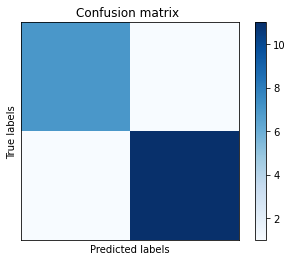

In [121]:

from sklearn.metrics import confusion_matrix, plot_confusion_matrix
from keras.models import load_model
loaded_model = buildModelFromDisk('./checkpoint.h5')


y_pred = loaded_model.predict_generator(validation_generator)
y_pred_argmax = [i.argmax() for i in y_pred]
y_true = validation_generator.classes

cm = confusion_matrix(y_true, y_pred_argmax)

print (cm)

total = sum(sum(cm))
hits = 0
for i in range(0,2):
  hits += cm[i][i]

print ('accuracy: ' + str ((hits / total)*100))


plt.imshow(cm, cmap=plt.cm.Blues)
plt.xlabel("Predicted labels")
plt.ylabel("True labels")
plt.xticks([], [])
plt.yticks([], [])
plt.title('Confusion matrix ')
plt.colorbar()
plt.show()

##**/tests folder**

prediction for /content/drive/My Drive/CAI/healthy_vs_sicks/v_data2/tests/test_1.jpg
[[0.9235145  0.07648557]]
healthy
prediction for /content/drive/My Drive/CAI/healthy_vs_sicks/v_data2/tests/test_2.jpg
[[0.90178674 0.09821329]]
healthy
prediction for /content/drive/My Drive/CAI/healthy_vs_sicks/v_data2/tests/test_3.jpg
[[0.8674046  0.13259545]]
healthy
prediction for /content/drive/My Drive/CAI/healthy_vs_sicks/v_data2/tests/test_4.jpg
[[0.7470962  0.25290388]]
healthy
prediction for /content/drive/My Drive/CAI/healthy_vs_sicks/v_data2/tests/test_fe_deficiency.jpg
[[0.29454356 0.70545644]]
sick
prediction for /content/drive/My Drive/CAI/healthy_vs_sicks/v_data2/tests/healthy-marijuana-leaf.jpg
[[0.8420437  0.15795627]]
healthy
prediction for /content/drive/My Drive/CAI/healthy_vs_sicks/v_data2/tests/sick.jpg
[[0.45318604 0.5468139 ]]
sick
prediction for /content/drive/My Drive/CAI/healthy_vs_sicks/v_data2/tests/broken.jpg
[[0.7969236  0.20307645]]
healthy
prediction for /content/driv

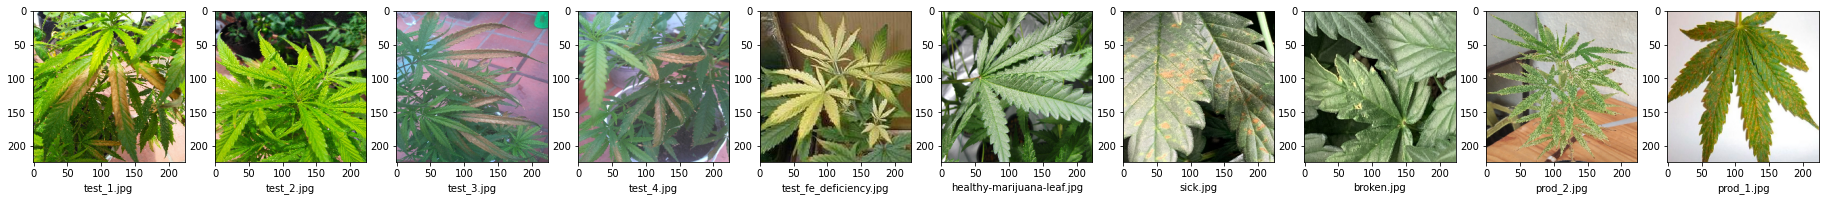

In [118]:
# SNIPPET TO LOAD DATA FROM DIRECTORY, FOR MANUAL WORK WITHOUT GENERATORS

import cv2
import glob
import numpy as np
import matplotlib.pyplot as plt
from keras.preprocessing import image

x_data = []
files = glob.glob (TEST_DIR + '/*.jpg') 

fig=plt.figure(figsize=(32, 32))
plotted_images = 1 

loaded_model = buildModelFromDisk('./checkpoint.h5')
predictions = []

for image_source in files:
    (image_original, image_tensor) = buildSampleFromDisk(image_source)

    fig.add_subplot(1, len(files), plotted_images) # subplot(rows, colums, currentIndexToPlot)
    plotted_images +=1
    
    image_label = image_source.split('/')[-1]
    plt.imshow(image_original)
    plt.xlabel(image_label)


    prediction = loaded_model.predict(image_tensor)
    print('prediction for ' + str(image_source))
    print(prediction)
    
    pred_label = prediction.argmax()

    if(pred_label == 0):
      print('healthy')
    else:
      print('sick')
  
